In [ ]:
pip install allensdk

# Imports


In [2]:


from allensdk.api.queries.image_download_api import ImageDownloadApi
from allensdk.api.queries.synchronization_api import SynchronizationApi
from allensdk.config.manifest import Manifest
from allensdk.core.reference_space_cache import ReferenceSpaceCache
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import logging
import os
from base64 import b64encode
import numpy as np
from IPython.display import HTML, display
%matplotlib inline
from PIL import Image
import copy


# Utils

## Configs

In [3]:
reference_space_key = 'annotation/ccf_2017' # the reference space key to use
resolution = 25 # the resolution to use options are 10, 25, 50, 100
rows_list = [] # the list of rows to store rois information vefore converting to dataframe
# The structure data set ids to use. Chosen by hand because of the errors in that can occur in the samples.
structure_data_set_ids_list = [70928385,71249069,71836787,71836878,72081516,72119628,73520964,73521804,73636030,73771240,75042244,75650864,76135829,77413698,79488931,79591637,79912554]
# The structure data set ids to extract the rois from.
structure_ids_list = [1056, #ANcr1
                     507, # MOB
                     726 # DG
                     ]

## API & modul instances 

In [4]:

image_api = ImageDownloadApi()
sync_api = SynchronizationApi()
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=os.path.join("allen_ccf", "manifest.json")) 
tree = rspc.get_structure_tree(structure_graph_id=1) # The structure tree to use for extracting information about the structures (acronym, names, ids ...)
annotation, meta = rspc.get_annotation_volume() # the annotation volume to use for getting the labels of regions
rsp = rspc.get_reference_space() 


2022-08-15 12:06:26,743 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd


## Plotters

In [5]:
def verify_image(file_path, figsize=(18, 22)):
    image = imread(file_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    

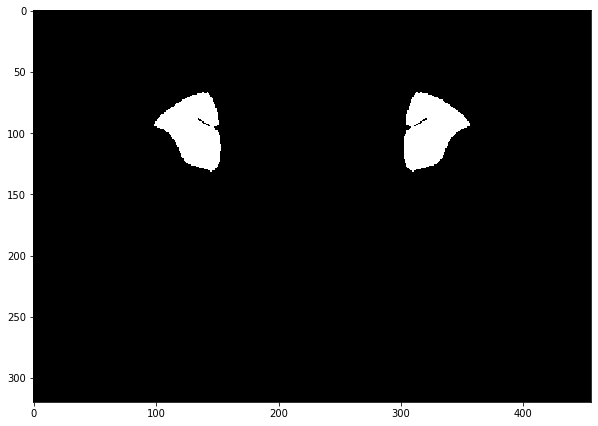

In [22]:

# A complete mask for one structure Ancr1
whole_cortex_mask = rsp.make_structure_mask([1056])

# view in coronal section of one slice
fig, ax = plt.subplots(figsize=(10, 10))
mask = copy.deepcopy(whole_cortex_mask[480, :,:])
plt.imshow(mask, interpolation='none', cmap=plt.cm.afmhot)

7


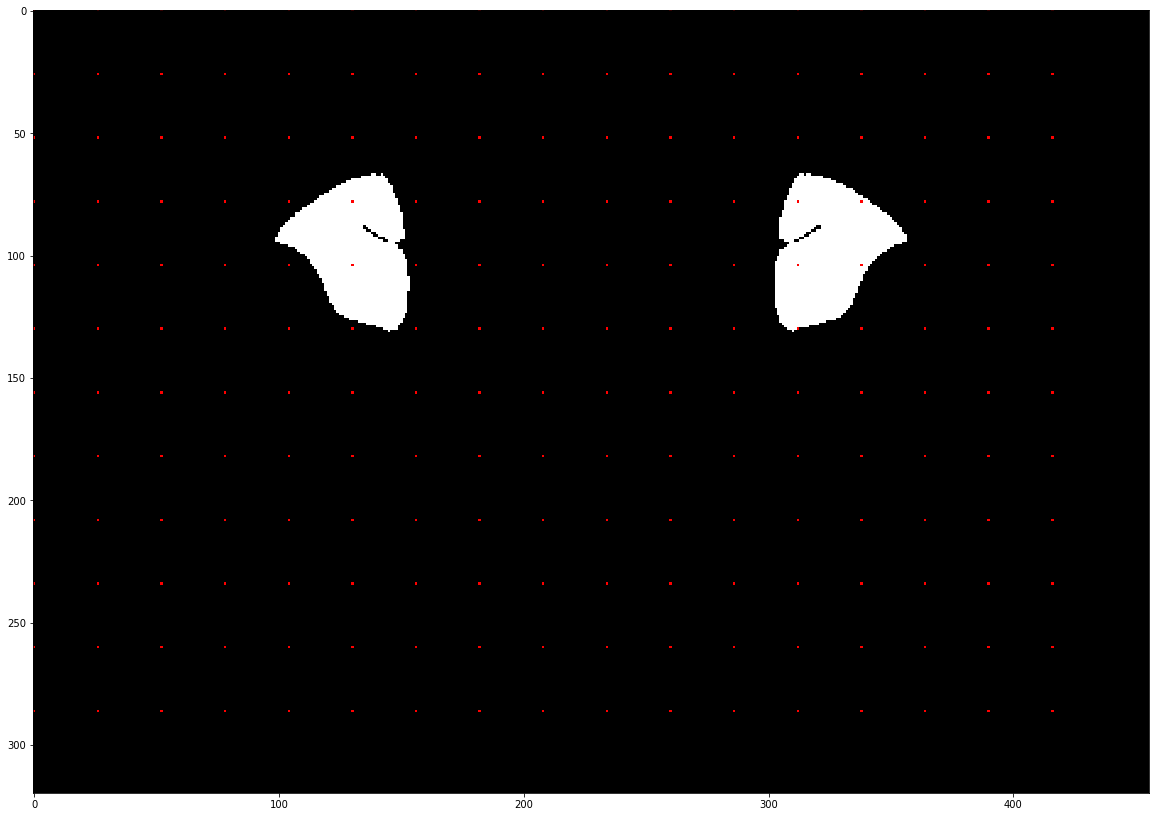

In [107]:
# We iterate on slices to get the reference coordinates of points that are inside the mask of the structure.
# The red points represent the steps we are performing. If the points is inside the mask, we get it's reference coordinates.
whole_cortex_mask = rsp.make_structure_mask([1056])
mask = copy.deepcopy(whole_cortex_mask[480, :,:])
(mask_width, mask_height) = mask.shape
frames = np.empty((mask_width, mask_height, 3)) # constructing RGB image for demonstration
frames[:,:,0] = mask
frames[:,:,1] = mask
frames[:,:,2] = mask
count = 0
#We use downsampling when we acquire the images of size 1. Therefore, we need to double the size of the steps we are making to avoid overlapping between the resulting Rois. 
w = int(334*2 / 25)
h = int(334*2 / 25)
(mask_width, mask_height, mask_rgb) = frames.shape
for i in range(int(mask_width / w)):
    for j in range(int(mask_height / h)):
      if frames[i*w][j*h][0] > 0:
        count +=1
      frames[i*w][j*h][0] = 255
      frames[i*w][j*h][1] = 0
      frames[i*w][j*h][2] = 0
        
print(count)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(frames, interpolation='none', cmap=plt.cm.afmhot)

# Getting and storing an image from index of center in the reference space

In [113]:
 rm -r '/content/rspv_1085'

rm: cannot remove '/content/rspv_1085': No such file or directory


In [114]:
 rm -r '/content/MOB_507'

In [115]:
rm -r '/content/DG_726'

In [116]:
 rm -r '/content/ANcr1___1085'

rm: cannot remove '/content/ANcr1___1085': No such file or directory


In [86]:
def getROIByIndex(section_image_id,x,y,width,height,destination_path):
    """ This function gets the ROI from the Allen Brain section image and saves it in the destination_path. 
    Parameters:
    -----------
    section_image_id: int
        The id of the section image to get the ROI from.
    x: int
        The x coordinate of the ROI.
    y: int
        The y coordinate of the ROI.
    width: int
        The width of the ROI.
    height: int
        The height of the ROI.
    destination_path: str
        The path to save the ROI.
    """

  image_api.download_section_image(section_image_id, destination_path, top = y, left = x, width = width, height = height,downsample_dimensions  = False,downsample = 1)
  #verify_image(destination_path)
#getROIByIndex(79455317,7000-334,2000-334,334,334,'69750516.jpg')

In [77]:
def get_reference_to_image(x,y,z,section_data_set_ids,reference_space_id,structure_acronym,structure_id,width,height):
    """ This function gets the image from a reference space coordination for a list of section data sets.
    Parameters:
    -----------
    x: int 
        The x coordinate in the reference space.
    y: int
        The y coordinate in the reference space.
    z: int
        The z coordinate in the reference space.
    section_data_set_ids: list of int
        The list of section data set ids to get the Rois from.
    reference_space_id: int
        The id of the reference space 9 is for coronal data, 10 is for sagittal data.
    structure_acronym: str
        The acronym of the structure.
    structure_id: int
        The id of the structure.
    width: int
        The width of the ROI.
    height: int
        The height of the ROI.
    Returns:
    --------
    None.
    """
  # get the section image id and the x, y coordinates of the point in the reference space for the specific strucure data set.
  json_response  = sync_api.get_reference_to_image(x=x, y=  y, z= z, section_data_set_ids=section_data_set_ids,reference_space_id=reference_space_id)
  format_str = '.jpg'
  overlap = False 
  # to check if the new ROI overlap with an old one. if there is less then 100 distance on the x and y coords we skip it.
  # the api call will return the closet available coordinates and section image in the dataset. Sometimes the thickness of the dataset or section is high. so the 
  # api will return the closest the same point more than one. we prevent this by setting a threshold on distance between the points of the same section image.
  for row in json_response:
    response_body = row['image_sync']
    for item in rows_list:
      if item['section_image_id'] == response_body['section_image_id'] and ( (abs(item['x_sec'] - response_body['x']) < 100) and (abs(item['y_sec'] - response_body['y']) < 100)):
        print("Warning: overlaped images will not be saved" )   
        overlap = True
        #print(overlap)
        break
    if overlap == True:     
      overlap == False
      continue
      
    directory_name = structure_acronym +'_'+ str(structure_id) # name of the directory acronym + structure id
    file_name = f"si-{response_body['section_image_id']}_x-{response_body['x']}_y-{response_body['y']}{format_str}"
    destination_path = os.path.join(directory_name, file_name)
    print(destination_path)
    Manifest.safe_make_parent_dirs(destination_path) 
    getROIByIndex(response_body['section_image_id'],response_body['x'],response_body['y'],width,height,destination_path)
    #saving the ROI information into a list. so we can create a csvs file later.
    dict1 = { 'section_data_set_id': response_body['section_data_set_id'],
                  'section_image_id': response_body['section_image_id'],
                  'x_sec':response_body['x'],
                  'y_sec':response_body['y'],
                  'structure_acronym':structure_acronym,
                  'structure_id':structure_id,
                  'x_ref':x,
                  'y_ref':y,
                  'z_ref':z,
                  'destination':destination_path}
    rows_list.append(dict1)
# get_reference_to_image(x=11430, y=  2826, z= 1814, section_data_set_ids=[79488931],reference_space_id=9,structure_acronym='ANcr1__',structure_id=1085,width=334,height=334)

2022-08-15 12:31:30,384 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/79455317?downsample=1&left=702&top=2037&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/79455317?downsample=1&left=702&top=2037&width=334&height=334&downsample_dimensions=false


ANcr1___1085/79455317_702.3397795831038_2037.542121419367.jpg


In [110]:
def getROIsFrom3DMasks_per_structure(mask,section_data_set_ids,structure_acronym,structure_id,reference_space_id,resolution,width,height):
    """ This function gets the ROIs from a 3D mask for a list of section data sets.
    Parameters:
    -----------
    mask: numpy array
        The 3D mask of the structure. 
    section_data_set_ids: list of int
        The list of section data set ids to get the Rois from.
    structure_acronym: str
        The acronym of the structure.
    structure_id: int
        The id of the structure.
    reference_space_id: int
        The id of the reference space 9 is for coronal data, 10 is for sagittal data.
    resolution: int
        The resolution of the reference space that is being used (10, 25, 50, 100).
    width: int
        The width of the ROI.
    height: int
        The height of the ROI.
    Returns:
    --------
        count of the ROIS for the specific structure
    """
  #We use downsampling of size 1 when we acquire the images, to get bigger images with more information. Therefore, we need to double the size of the steps we are making 
  #to avoid overlapping between the resulting Rois. 
  w = int(width*2 / resolution)
  h = int(height*2 / resolution)
  steps_on_z_axis = 4 # steps to skip layers on the z axis. otherwise we will make a lot of uneccessary calls. 4 for the dataset of 20 thickness. 
  # and 8 for the dataset of 25 thickness.
  count = 0
  (mask_depth,mask_width, mask_height) = mask.shape
  print(mask.shape)
  for k in range(int(mask_depth/steps_on_z_axis)):
    for i in range(int(mask_width / w)):
      for j in range(int(mask_height / h)):
        if mask[k*steps_on_z_axis][i*w][j*h] > 0:
          get_reference_to_image(z=j*h*resolution-width/2,
                                y=i*w*resolution-height/2,
                                x= k*25*steps_on_z_axis,
                                section_data_set_ids=section_data_set_ids,
                                reference_space_id=reference_space_id,
                                structure_acronym=structure_acronym,
                                structure_id=structure_id,
                                width=width,
                                height=height)
          count +=1
  return count

# mask = copy.deepcopy(whole_cortex_mask[480, :,:])
# mask_3D = copy.deepcopy(whole_cortex_mask)
# x = getROIsFrom3DMasks_per_structure(mask_3D,section_data_set_ids=[74511839],reference_space_id=9,structure_acronym='DG',structure_id=726,width=334,height=334,resolution = 25) #79488931 507, # MOB 726 # DG
# print(x)

In [118]:
def getROIsFrom3DMasks(section_data_set_ids,structure_id_list,reference_space_id,resolution,width,height):
    """ This function gets the ROIs of strucure ids from a list of section data sets.
    Parameters:
    -----------
    section_data_set_ids: list of int
        The list of section data set ids to get the Rois from.
    structure_id_list: list of int
        The list of trageted structure ids.
    reference_space_id: int
        The id of the reference space 9 is for coronal data, 10 is for sagittal data.
    resolution: int
        The resolution of the reference space that is being used (10, 25, 50, 100).
    width: int
        The width of the ROI.
    height: int
        The height of the ROI.
    Returns:
    --------
    None.
    """
  #get structures from their id.
  structure_infos = tree.get_structures_by_id(structure_id_list)
  for st in structure_infos:
    # A complete 3D mask for one structure
    whole_cortex_mask = rsp.make_structure_mask([st['id']])
    count = getROIsFrom3DMasks_per_structure(whole_cortex_mask,
                                         section_data_set_ids=section_data_set_ids,
                                         reference_space_id=9,
                                         structure_acronym=st['acronym'],
                                         structure_id=st['id'],
                                         width=width,
                                         height=height,
                                         resolution = resolution
                                         )
# test on one dataset and three structures. results in 406 ROIS.
getROIsFrom3DMasks([74511839],[726,1056,507],9,25,334,334)
#1056 ANcr1
#507  MOB
#726  DG

2022-08-15 13:59:37,817 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409334?downsample=1&left=5193&top=2151&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409334?downsample=1&left=5193&top=2151&width=334&height=334&downsample_dimensions=false


(528, 320, 456)
DG_726/74409334_5193.277545652707_2151.9958731898228.jpg


2022-08-15 13:59:37,950 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409330?downsample=1&left=5206&top=2432&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409330?downsample=1&left=5206&top=2432&width=334&height=334&downsample_dimensions=false


DG_726/74409330_5206.91432368166_2432.5434219107187.jpg


2022-08-15 13:59:38,212 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409932?downsample=1&left=4414&top=2000&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409932?downsample=1&left=4414&top=2000&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:38,302 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409932?downsample=1&left=5014&top=1995&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409932?downsample=1&left=5014&top=1995&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:38,404 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409932_4414.892855446948_2000.6966689997319.jpg
DG_726/74409932_5014.005119607592_1995.5652303450518.jpg
DG_726/74409328_4591.478044773326_2612.873780770336.jpg


2022-08-15 13:59:38,491 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409328?downsample=1&left=5190&top=2604&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409328?downsample=1&left=5190&top=2604&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:38,601 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409328?downsample=1&left=5789&top=2595&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409328?downsample=1&left=5789&top=2595&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:38,691 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409328_5190.548180167681_2604.1411707737057.jpg
DG_726/74409328_5789.618315562034_2595.4085607770753.jpg
DG_726/74409930_4631.432957997574_2536.5998648369896.jpg


INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409930?downsample=1&left=4631&top=2536&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:38,963 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409930?downsample=1&left=5230&top=2534&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409930?downsample=1&left=5230&top=2534&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:39,085 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409930?downsample=1&left=5829&top=2532&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_dow

DG_726/74409930_5230.563715454741_2534.6731395924544.jpg
DG_726/74409930_5829.694472911908_2532.74641434792.jpg


2022-08-15 13:59:39,182 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409326?downsample=1&left=4583&top=2352&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409326?downsample=1&left=4583&top=2352&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:39,280 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409326?downsample=1&left=5781&top=2338&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409326?downsample=1&left=5781&top=2338&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:39,368 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409326_4583.512098846106_2352.3643161427603.jpg
DG_726/74409326_5781.698075634348_2338.30169304499.jpg
DG_726/74409928_4682.76956185923_2502.5922027269216.jpg


2022-08-15 13:59:39,447 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409928?downsample=1&left=5880&top=2491&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409928?downsample=1&left=5880&top=2491&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:39,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409324?downsample=1&left=4195&top=2550&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409324?downsample=1&left=4195&top=2550&width=334&height=334&downsample_dimensions=false


DG_726/74409928_5880.981915184282_2491.032076619781.jpg
DG_726/74409324_4195.269782213029_2550.831374718653.jpg


2022-08-15 13:59:39,651 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409324?downsample=1&left=4794&top=2548&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409324?downsample=1&left=4794&top=2548&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:39,785 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409324?downsample=1&left=5992&top=2543&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409324?downsample=1&left=5992&top=2543&width=334&height=334&downsample_dimensions=false


DG_726/74409324_4794.399235311335_2548.479542475243.jpg
DG_726/74409324_5992.658141507948_2543.7758779884234.jpg


2022-08-15 13:59:39,899 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409924?downsample=1&left=4131&top=2514&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409924?downsample=1&left=4131&top=2514&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:39,994 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409924?downsample=1&left=4730&top=2508&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409924?downsample=1&left=4730&top=2508&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,085 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409924_4131.673990322591_2514.9026473147064.jpg
DG_726/74409924_4730.772497596558_2508.3677398384666.jpg
DG_726/74409924_5928.969512144496_2495.297924885986.jpg


2022-08-15 13:59:40,177 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409924?downsample=1&left=6528&top=2488&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409924?downsample=1&left=6528&top=2488&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,267 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409320?downsample=1&left=4141&top=2813&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409320?downsample=1&left=4141&top=2813&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,358 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409924_6528.068019418463_2488.7630174097458.jpg
DG_726/74409320_4141.532366522611_2813.34655589796.jpg
DG_726/74409320_4740.637976589692_2807.491366579735.jpg


2022-08-15 13:59:40,445 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409320?downsample=1&left=5938&top=2795&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409320?downsample=1&left=5938&top=2795&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409320?downsample=1&left=6537&top=2789&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409320?downsample=1&left=6537&top=2789&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,623 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409320_5938.849196723854_2795.7809879432843.jpg
DG_726/74409320_6537.9548067909345_2789.925798625059.jpg
DG_726/74409922_4122.9314121704265_2009.0057887043824.jpg


2022-08-15 13:59:40,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409922?downsample=1&left=4722&top=2006&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409922?downsample=1&left=4722&top=2006&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,795 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409922?downsample=1&left=5920&top=2001&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409922?downsample=1&left=5920&top=2001&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:40,890 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409922_4722.060125397666_2006.457975402907.jpg
DG_726/74409922_5920.317551852144_2001.3623487999573.jpg
DG_726/74409922_6519.446265079383_1998.8145354984824.jpg


2022-08-15 13:59:40,981 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409318?downsample=1&left=3651&top=2067&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409318?downsample=1&left=3651&top=2067&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,071 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409318?downsample=1&left=4250&top=2065&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409318?downsample=1&left=4250&top=2065&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,162 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409318_3651.5488034089212_2067.4354085757486.jpg
DG_726/74409318_4250.678907689382_2065.2190671780227.jpg
DG_726/74409318_6048.069220530766_2058.5700429848484.jpg


2022-08-15 13:59:41,250 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409318?downsample=1&left=6647&top=2056&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409318?downsample=1&left=6647&top=2056&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,340 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409920?downsample=1&left=3479&top=2558&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409920?downsample=1&left=3479&top=2558&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,433 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409318_6647.199324811227_2056.3537015871234.jpg
DG_726/74409920_3479.661444737445_2558.264215664298.jpg
DG_726/74409920_4078.76897610977_2552.641189232938.jpg


2022-08-15 13:59:41,529 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409920?downsample=1&left=5876&top=2535&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409920?downsample=1&left=5876&top=2535&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,692 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409920?downsample=1&left=6475&top=2530&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409920?downsample=1&left=6475&top=2530&width=334&height=334&downsample_dimensions=false


DG_726/74409920_5876.091570226741_2535.7721099388573.jpg
DG_726/74409920_6475.199101599066_2530.1490835074974.jpg


2022-08-15 13:59:41,785 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409316?downsample=1&left=3566&top=2238&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409316?downsample=1&left=3566&top=2238&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,894 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409316?downsample=1&left=4165&top=2244&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409316?downsample=1&left=4165&top=2244&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:41,984 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409316_3566.0690888298654_2238.382634827293.jpg
DG_726/74409316_4165.175326886372_2244.1592687625725.jpg
DG_726/74409316_6561.600279112405_2267.2658045036924.jpg


INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409316?downsample=1&left=6561&top=2267&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:42,102 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409918?downsample=1&left=2978&top=2631&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409918?downsample=1&left=2978&top=2631&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:42,189 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409918?downsample=1&left=3578&top=2624&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_dow

DG_726/74409918_2978.925906110659_2631.5372910140413.jpg
DG_726/74409918_3578.021398322707_2624.7559820037213.jpg
DG_726/74409918_6573.498859382948_2590.8494369521213.jpg


2022-08-15 13:59:42,390 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409314?downsample=1&left=2849&top=2454&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409314?downsample=1&left=2849&top=2454&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:42,483 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409314?downsample=1&left=3449&top=2453&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409314?downsample=1&left=3449&top=2453&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:42,581 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409314_2849.975679173124_2454.5249535826065.jpg
DG_726/74409314_3449.1092938531524_2453.9760196463412.jpg
DG_726/74409314_7043.910981933326_2450.682416028752.jpg


2022-08-15 13:59:42,689 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409314?downsample=1&left=7643&top=2450&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409314?downsample=1&left=7643&top=2450&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:42,783 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409914?downsample=1&left=2922&top=2606&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409914?downsample=1&left=2922&top=2606&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:42,871 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409314_7643.044596613354_2450.1334820924867.jpg
DG_726/74409914_2922.786934749063_2606.7765123977542.jpg
DG_726/74409914_3521.878980587426_2613.8902433337544.jpg


2022-08-15 13:59:42,964 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409914?downsample=1&left=7116&top=2656&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409914?downsample=1&left=7116&top=2656&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,058 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409914?downsample=1&left=7715&top=2663&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409914?downsample=1&left=7715&top=2663&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,140 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409914_7116.431255617611_2656.572628949755.jpg
DG_726/74409914_7715.5233014559735_2663.6863598857553.jpg
DG_726/74409310_2912.2521575256105_2588.6226331879325.jpg


2022-08-15 13:59:43,230 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409310?downsample=1&left=3511&top=2584&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409310?downsample=1&left=3511&top=2584&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,314 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409310?downsample=1&left=7106&top=2562&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409310?downsample=1&left=7106&top=2562&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,414 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409310_3511.374811648226_2584.907098293172.jpg
DG_726/74409310_7106.110736383922_2562.613888924612.jpg
DG_726/74409310_7705.233390506537_2558.8983540298523.jpg


2022-08-15 13:59:43,495 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409912?downsample=1&left=2981&top=2083&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409912?downsample=1&left=2981&top=2083&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,585 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409912?downsample=1&left=3580&top=2079&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409912?downsample=1&left=3580&top=2079&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,684 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409912_2981.5868845182804_2083.2755949988623.jpg
DG_726/74409912_3580.706745674277_2079.147138063532.jpg
DG_726/74409912_7175.425912610265_2054.3763964515533.jpg


2022-08-15 13:59:43,780 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409912?downsample=1&left=7774&top=2050&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409912?downsample=1&left=7774&top=2050&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:43,859 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=2983&top=3305&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=2983&top=3305&width=334&height=334&downsample_dimensions=false


DG_726/74409912_7774.545773766262_2050.247939516223.jpg
DG_726/74409308_2983.383811366928_3305.525654220036.jpg


2022-08-15 13:59:44,007 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=3582&top=3300&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=3582&top=3300&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,089 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=7177&top=3273&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=7177&top=3273&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,180 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409308_3582.500240132639_3300.945434645975.jpg
DG_726/74409308_7177.1988127269115_3273.4641172016163.jpg
DG_726/74409308_7776.315241492623_3268.8838976275556.jpg


2022-08-15 13:59:44,271 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=2388&top=3919&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=2388&top=3919&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,357 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=2987&top=3914&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409308?downsample=1&left=2987&top=3914&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,442 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409308_2388.0639439332854_3919.1962507703975.jpg
DG_726/74409308_2987.1803726989974_3914.6160311963367.jpg
DG_726/74409910_3018.007171083104_1908.0272473647515.jpg


2022-08-15 13:59:44,536 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=3617&top=1901&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=3617&top=1901&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,637 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=7211&top=1860&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=7211&top=1860&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409910_3617.102018757869_1901.1684250941266.jpg
DG_726/74409910_7211.671104806459_1860.0154914703762.jpg
DG_726/74409910_7810.7659524812225_1853.1566691997514.jpg


2022-08-15 13:59:44,817 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=2425&top=2523&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=2425&top=2523&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:44,922 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=3024&top=2517&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=3024&top=2517&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,017 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409910_2425.0254270465393_2523.957776755942.jpg
DG_726/74409910_3024.120274721304_2517.0989544853173.jpg
DG_726/74409910_7822.992159757623_3071.3000834408813.jpg


INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=7822&top=3071&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,113 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=3647&top=4946&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=3647&top=4946&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,210 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409910?downsample=1&left=7242&top=4905&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_dow

DG_726/74409910_3647.6675369488685_4946.526960696952.jpg
DG_726/74409910_7242.236622997458_4905.374027073202.jpg
DG_726/74409306_2923.2576868253145_2481.954651389732.jpg


2022-08-15 13:59:45,406 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=3522&top=2477&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=3522&top=2477&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,501 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=7117&top=2449&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=7117&top=2449&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,598 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409306_3522.3736489796865_2477.321625626652.jpg
DG_726/74409306_7117.06942190592_2449.523471048172.jpg
DG_726/74409306_7716.185384060288_2444.8904452850916.jpg


2022-08-15 13:59:45,680 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=2327&top=3095&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=2327&top=3095&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,763 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=2927&top=3091&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=2927&top=3091&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:45,864 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409306_2327.9919713872328_3095.677655542874.jpg
DG_726/74409306_2927.107933541605_3091.0446297797935.jpg
DG_726/74409306_7723.885877492869_3663.0704020652156.jpg


2022-08-15 13:59:45,955 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=8323&top=3658&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=8323&top=3658&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,043 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=3541&top=5522&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409306?downsample=1&left=3541&top=5522&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,140 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409306_8323.001839647242_3658.437376302135.jpg
DG_726/74409306_3541.6248825611374_5522.771517576962.jpg
DG_726/74409306_7136.320655487369_5494.973362998481.jpg


2022-08-15 13:59:46,255 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=2899&top=2422&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=2899&top=2422&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,348 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=3498&top=2420&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=3498&top=2420&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,440 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409908_2899.4284382632695_2422.4167367984905.jpg
DG_726/74409908_3498.560358581603_2420.8337530253402.jpg
DG_726/74409908_7093.3518804916075_2411.335850386441.jpg


2022-08-15 13:59:46,536 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=2301&top=3033&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=2301&top=3033&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,630 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=2900&top=3031&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=2900&top=3031&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,724 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409908_2301.0459568577558_3033.1015451649546.jpg
DG_726/74409908_2900.1778771760896_3031.518561391804.jpg
DG_726/74409908_7693.233239722761_3018.854691206605.jpg


2022-08-15 13:59:46,820 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=7693&top=3627&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=7693&top=3627&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:46,909 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=8293&top=3626&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=8293&top=3626&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,004 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409908_7693.982678635582_3627.9565157999186.jpg
DG_726/74409908_8293.114598953915_3626.3735320267688.jpg
DG_726/74409908_7695.481556461221_4846.160164986547.jpg


2022-08-15 13:59:47,101 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=7097&top=5456&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409908?downsample=1&left=7097&top=5456&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=4327&top=3192&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=4327&top=3192&width=334&height=334&downsample_dimensions=false


DG_726/74409908_7097.0990750557075_5456.8449733530115.jpg
DG_726/74409304_4327.4385843632035_3192.0691195974023.jpg


2022-08-15 13:59:47,318 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=8517&top=3013&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=8517&top=3013&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,409 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=3753&top=3826&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=3753&top=3826&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,499 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409304_8517.591636306699_3013.887958349767.jpg
DG_726/74409304_3753.8641156324984_3826.112068175792.jpg
DG_726/74409304_4352.457408767284_3800.6576165689867.jpg


2022-08-15 13:59:47,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=9141&top=3597&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=9141&top=3597&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,670 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=9166&top=4205&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=9166&top=4205&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,783 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409304_9141.203753845562_3597.022003714547.jpg
DG_726/74409304_9166.222578249643_4205.610500686132.jpg
DG_726/74409304_9764.815871384426_4180.156049079326.jpg


INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=9764&top=4180&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,873 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=3803&top=5043&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=3803&top=5043&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:47,961 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409304?downsample=1&left=9216&top=5422&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_dow

DG_726/74409304_3803.901764440658_5043.289062118963.jpg
DG_726/74409304_9216.260227057803_5422.787494629303.jpg
DG_726/74409304_8642.685758327098_6056.830443207693.jpg


2022-08-15 13:59:48,233 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2865&top=2423&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2865&top=2423&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:48,337 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=7059&top=2402&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=7059&top=2402&width=334&height=334&downsample_dimensions=false


DG_726/74409904_2865.2020070355097_2423.835643872761.jpg
DG_726/74409904_7059.087569719691_2402.6974744481154.jpg
DG_726/74409904_2268.2856024634766_3035.953767610089.jpg

2022-08-15 13:59:48,436 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2268&top=3035&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2268&top=3035&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:48,521 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2867&top=3032&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2867&top=3032&width=334&height=334&downsample_dimensions=false



DG_726/74409904_2867.41211141836_3032.9340291208546.jpg


2022-08-15 13:59:48,704 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=7660&top=3008&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=7660&top=3008&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:48,798 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=7662&top=3617&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=7662&top=3617&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:48,890 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409904_7660.424183057425_3008.7761212069727.jpg
DG_726/74409904_7662.634287440273_3617.8745064550667.jpg
DG_726/74409904_8261.760796395156_3614.8547679658313.jpg


2022-08-15 13:59:48,990 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2272&top=4254&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2272&top=4254&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,084 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2871&top=4251&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409904?downsample=1&left=2871&top=4251&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,177 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409904_2272.705811229177_4254.150538106274.jpg
DG_726/74409904_2871.83232018406_4251.130799617039.jpg
DG_726/74409904_7667.054496205972_4836.071276951253.jpg


2022-08-15 13:59:49,267 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2846&top=2362&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2846&top=2362&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,352 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2249&top=2974&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2249&top=2974&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,437 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409300_2846.501848720043_2362.6685411435233.jpg
DG_726/74409300_2249.1066900275036_2974.3192835349137.jpg
DG_726/74409300_2848.2353027507934_2971.768392265363.jpg


2022-08-15 13:59:49,519 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=7641&top=2951&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=7641&top=2951&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,601 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=7642&top=3560&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=7642&top=3560&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,694 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409300_7641.26420453711_2951.3612621089633.jpg
DG_726/74409300_7642.997658567863_3560.4611132308037.jpg
DG_726/74409300_8242.126271291154_3557.910221961254.jpg


2022-08-15 13:59:49,817 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2252&top=4192&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2252&top=4192&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:49,902 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2851&top=4189&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=2851&top=4189&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,002 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409300_2252.573598089003_4192.518985778594.jpg
DG_726/74409300_2851.702210812293_4189.968094509044.jpg
DG_726/74409300_2853.435664843043_4799.0679456308835.jpg


2022-08-15 13:59:50,090 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=7646&top=4778&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409300?downsample=1&left=7646&top=4778&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,175 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2239&top=2805&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2239&top=2805&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,268 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409300_7646.464566629364_4778.660815474484.jpg
DG_726/74409902_2239.6832754248812_2805.6623655070634.jpg
DG_726/74409902_2838.791405721024_2811.227337541828.jpg


2022-08-15 13:59:50,356 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=7631&top=2855&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=7631&top=2855&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,435 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2233&top=3414&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2233&top=3414&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,527 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409902_7631.656448090168_2855.747113819947.jpg
DG_726/74409902_2233.165873628781_3414.729745464866.jpg
DG_726/74409902_7625.13904629407_3464.8144937777506.jpg


2022-08-15 13:59:50,622 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=8224&top=3470&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=8224&top=3470&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,730 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2226&top=4023&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2226&top=4023&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,818 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409902_8224.24717659021_3470.3794658125153.jpg
DG_726/74409902_2226.648471832681_4023.7971254226695.jpg
DG_726/74409902_2825.7566021288244_4029.362097457434.jpg


2022-08-15 13:59:50,903 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=7618&top=4073&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=7618&top=4073&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:50,996 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2819&top=4638&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409902?downsample=1&left=2819&top=4638&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,086 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409902_7618.621644497966_4073.881873735554.jpg
DG_726/74409902_2819.2392003327245_4638.429477415237.jpg
DG_726/74409902_7612.1042427018665_4682.949253693357.jpg


2022-08-15 13:59:51,180 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=2191&top=2879&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=2191&top=2879&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,275 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7583&top=2919&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7583&top=2919&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,363 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409298_2191.0702701205623_2879.213750604304.jpg
DG_726/74409298_7583.125376866662_2919.848523015004.jpg
DG_726/74409298_2185.6203211667626_3488.2918927742044.jpg


2022-08-15 13:59:51,455 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7577&top=3528&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7577&top=3528&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,543 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=8176&top=3533&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=8176&top=3533&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,640 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409298_7577.675427912863_3528.9266651849034.jpg
DG_726/74409298_8176.7926619957625_3533.441639897204.jpg
DG_726/74409298_2180.1703722129623_4097.370034944104.jpg


2022-08-15 13:59:51,725 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=2779&top=4101&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=2779&top=4101&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,805 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7572&top=4138&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7572&top=4138&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:51,888 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409298_2779.287606295862_4101.885009656404.jpg
DG_726/74409298_7572.225478959062_4138.004807354804.jpg
DG_726/74409298_2773.8376573420624_4710.963151826303.jpg


2022-08-15 13:59:51,972 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7566&top=4747&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409298?downsample=1&left=7566&top=4747&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:52,055 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=7554&top=2928&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=7554&top=2928&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:52,150 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409298_7566.77553000526_4747.0829495247035.jpg
DG_726/74409900_7554.536788815762_2928.865825347747.jpg
DG_726/74409900_2154.690880159291_3474.5970973343756.jpg


2022-08-15 13:59:52,241 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=7546&top=3537&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=7546&top=3537&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:52,330 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=2146&top=4083&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=2146&top=4083&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:52,420 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

DG_726/74409900_7546.524558711702_3537.9153377834755.jpg
DG_726/74409900_2146.6786500552307_4083.646609770104.jpg
DG_726/74409900_7538.512328607641_4146.964850219203.jpg


2022-08-15 13:59:52,534 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=2737&top=4699&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=2737&top=4699&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:52,623 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=7530&top=4756&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409900?downsample=1&left=7530&top=4756&width=334&height=334&downsample_dimensions=false


DG_726/74409900_2737.759050901439_4699.731482255731.jpg
DG_726/74409900_7530.500098503582_4756.0143626549325.jpg


2022-08-15 13:59:52,741 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409296?downsample=1&left=7490&top=4011&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409296?downsample=1&left=7490&top=4011&width=334&height=334&downsample_dimensions=false


DG_726/74409296_7490.0953392852925_4011.9411141571436.jpg


2022-08-15 13:59:53,220 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409882?downsample=1&left=7258&top=3095&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409882?downsample=1&left=7258&top=3095&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:53,319 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409278?downsample=1&left=7681&top=2296&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409278?downsample=1&left=7681&top=2296&width=334&height=334&downsample_dimensions=false


(528, 320, 456)
ANcr1_1056/74409882_7258.314497005487_3095.9024650818164.jpg
ANcr1_1056/74409278_7681.044084337765_2296.430025447976.jpg


2022-08-15 13:59:53,407 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409278?downsample=1&left=7701&top=2905&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409278?downsample=1&left=7701&top=2905&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:53,499 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409880?downsample=1&left=7453&top=1581&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409880?downsample=1&left=7453&top=1581&width=334&height=334&downsample_dimensions=false


ANcr1_1056/74409278_7701.11652989923_2905.20117240494.jpg
ANcr1_1056/74409880_7453.7250308145585_1581.0533035980404.jpg


2022-08-15 13:59:53,627 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409880?downsample=1&left=888&top=2427&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409880?downsample=1&left=888&top=2427&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:53,726 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409880?downsample=1&left=7474&top=2189&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409880?downsample=1&left=7474&top=2189&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:53,819 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409880_888.6613727198353_2427.5784088410683.jpg
ANcr1_1056/74409880_7474.842544691838_2189.789246072768.jpg
ANcr1_1056/74409880_7495.960058569114_2798.5251885474954.jpg


2022-08-15 13:59:53,904 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=1084&top=1366&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=1084&top=1366&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:53,993 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=7671&top=1162&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=7671&top=1162&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,080 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409276_1084.0633792585327_1366.2397449402852.jpg
ANcr1_1056/74409276_7671.378188270827_1162.1094156806425.jpg
ANcr1_1056/74409276_1102.0699444553475_1975.0760682876994.jpg


2022-08-15 13:59:54,169 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=7689&top=1770&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=7689&top=1770&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,259 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=8288&top=1752&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=8288&top=1752&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,362 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409276_7689.38475346764_1770.9457390280572.jpg
ANcr1_1056/74409276_8288.23155428694_1752.388436368089.jpg
ANcr1_1056/74409276_1120.0765096521623_2583.912391635114.jpg


2022-08-15 13:59:54,466 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=1718&top=2565&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=1718&top=2565&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,560 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=7707&top=2379&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409276?downsample=1&left=7707&top=2379&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,650 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409276_1718.9233104714622_2565.3550889751464.jpg
ANcr1_1056/74409276_7707.391318664458_2379.782062375472.jpg
ANcr1_1056/74409878_1053.277706292381_1690.8500708619677.jpg


2022-08-15 13:59:54,754 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=7641&top=1505&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=7641&top=1505&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,843 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=1069&top=2299&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=1069&top=2299&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:54,933 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409878_7641.144949020807_1505.5447593134677.jpg
ANcr1_1056/74409878_1069.5443625392354_2299.7349948067144.jpg
ANcr1_1056/74409878_1668.4413846054563_2282.8890573932154.jpg


2022-08-15 13:59:55,019 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=7657&top=2114&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=7657&top=2114&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,109 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=8256&top=2097&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=8256&top=2097&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,187 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409878_7657.411605267664_2114.4296832582145.jpg
ANcr1_1056/74409878_8256.308627333885_2097.5837458447154.jpg
ANcr1_1056/74409878_1085.8110187860889_2908.619918751461.jpg


2022-08-15 13:59:55,273 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=1684&top=2891&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=1684&top=2891&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=7673&top=2723&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409878?downsample=1&left=7673&top=2723&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,458 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409878_1684.7080408523098_2891.7739813379617.jpg
ANcr1_1056/74409878_7673.678261514517_2723.3146072029617.jpg
ANcr1_1056/74409274_1121.6438777036228_1214.9754698084203.jpg


2022-08-15 13:59:55,550 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=539&top=1841&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=539&top=1841&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,644 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=1138&top=1823&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=1138&top=1823&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,736 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409274_539.7988576555558_1841.4370839034796.jpg
ANcr1_1056/74409274_1138.674487901796_1823.839724490958.jpg
ANcr1_1056/74409274_7127.430790364196_1647.8661303657323.jpg


2022-08-15 13:59:55,833 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=556&top=2450&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=556&top=2450&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:55,926 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=1155&top=2432&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=1155&top=2432&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,012 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409274_556.829467853729_2450.301338586017.jpg
ANcr1_1056/74409274_1155.7050980999693_2432.7039791734946.jpg
ANcr1_1056/74409274_7144.461400562369_2256.7303850482695.jpg


2022-08-15 13:59:56,109 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=7743&top=2239&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=7743&top=2239&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,189 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=7161&top=2865&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409274?downsample=1&left=7161&top=2865&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,277 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409274_7743.337030808608_2239.1330256357473.jpg
ANcr1_1056/74409274_7161.492010760542_2865.5946397308066.jpg
ANcr1_1056/74409874_1518.074985373341_1503.9784940035931.jpg


2022-08-15 13:59:56,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=930&top=2125&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=930&top=2125&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,457 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=1529&top=2112&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=1529&top=2112&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,537 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409874_930.6715106109632_2125.2306907899056.jpg
ANcr1_1056/74409874_1529.6798966722308_2112.9700538099505.jpg
ANcr1_1056/74409874_942.2764219098531_2734.2222505962627.jpg


2022-08-15 13:59:56,623 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=1541&top=2721&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=1541&top=2721&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,711 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=6932&top=2611&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=6932&top=2611&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,796 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409874_1541.2848079711202_2721.9616136163077.jpg
ANcr1_1056/74409874_6932.3602825225225_2611.615880796712.jpg
ANcr1_1056/74409874_7531.368668583789_2599.355243816757.jpg


2022-08-15 13:59:56,895 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=8130&top=2587&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=8130&top=2587&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:56,981 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=7542&top=3208&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409874?downsample=1&left=7542&top=3208&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,077 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409874_8130.377054645056_2587.094606836802.jpg
ANcr1_1056/74409874_7542.9735798826805_3208.346803623115.jpg
ANcr1_1056/74409270_1464.5773747685641_1267.3737841730315.jpg


2022-08-15 13:59:57,169 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=6855&top=1167&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=6855&top=1167&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,248 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=875&top=1887&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=875&top=1887&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,341 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409270_6855.854337699851_1167.3584364664719.jpg
ANcr1_1056/74409270_875.9845636588323_1887.499273082243.jpg
ANcr1_1056/74409270_1475.0153373178644_1876.3864566704035.jpg


2022-08-15 13:59:57,440 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=6866&top=1776&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=6866&top=1776&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,533 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=7465&top=1765&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=7465&top=1765&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,620 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409270_6866.292300249153_1776.371108963843.jpg
ANcr1_1056/74409270_7465.323073908183_1765.2582925520026.jpg
ANcr1_1056/74409270_886.4225262081325_2496.511945579615.jpg


2022-08-15 13:59:57,711 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=1485&top=2485&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=1485&top=2485&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,802 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=6876&top=2385&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=6876&top=2385&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:57,887 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409270_1485.4532998671646_2485.3991291677758.jpg
ANcr1_1056/74409270_6876.730262798452_2385.3837814612143.jpg
ANcr1_1056/74409270_7475.761036457483_2374.2709650493744.jpg


2022-08-15 13:59:57,975 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=8074&top=2363&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409270?downsample=1&left=8074&top=2363&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,053 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=1367&top=1284&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=1367&top=1284&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,154 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409270_8074.791810116516_2363.1581486375353.jpg
ANcr1_1056/74409872_1367.586844093668_1284.2859028418854.jpg
ANcr1_1056/74409872_6758.758554065858_1178.7939577179307.jpg


2022-08-15 13:59:58,238 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=779&top=1905&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=779&top=1905&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,331 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=1378&top=1893&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=1378&top=1893&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,423 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409872_779.6243790330084_1905.0088865798596.jpg
ANcr1_1056/74409872_1378.6434579188078_1893.287559343865.jpg
ANcr1_1056/74409872_6769.815167890998_1787.7956142199093.jpg


2022-08-15 13:59:58,509 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=7368&top=1776&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=7368&top=1776&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,600 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=790&top=2514&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=790&top=2514&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,695 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409872_7368.834246776798_1776.074286983914.jpg
ANcr1_1056/74409872_790.6809928581486_2514.0105430818385.jpg
ANcr1_1056/74409872_1389.700071743948_2502.2892158458435.jpg


2022-08-15 13:59:58,798 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=6780&top=2396&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=6780&top=2396&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,888 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=7379&top=2385&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409872?downsample=1&left=7379&top=2385&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:58,978 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409872_6780.871781716138_2396.7972707218887.jpg
ANcr1_1056/74409872_7379.890860601938_2385.0759434858937.jpg
ANcr1_1056/74409872_7978.909939487736_2373.3546162498988.jpg


2022-08-15 13:59:59,066 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=1162&top=1158&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=1162&top=1158&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,161 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=6551&top=968&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=6551&top=968&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,245 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409268_1162.2753144972883_1158.1076826602307.jpg
ANcr1_1056/74409268_6551.138908618477_968.236436268066.jpg
ANcr1_1056/74409268_584.1011306062571_1787.9588761610066.jpg


2022-08-15 13:59:59,337 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=1182&top=1766&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=1182&top=1766&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,437 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=6571&top=1576&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=6571&top=1576&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,534 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409268_1182.8637521752783_1766.862071006322.jpg
ANcr1_1056/74409268_6571.727346296468_1576.9908246141567.jpg
ANcr1_1056/74409268_7170.489967865487_1555.8940194594716.jpg


2022-08-15 13:59:59,632 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=604&top=2396&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=604&top=2396&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,713 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=1203&top=2375&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=1203&top=2375&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,798 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409268_604.6895682842467_2396.713264507098.jpg
ANcr1_1056/74409268_1203.4521898532678_2375.6164593524127.jpg
ANcr1_1056/74409268_6592.315783974456_2185.745212960248.jpg


2022-08-15 13:59:59,879 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=7191&top=2164&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409268?downsample=1&left=7191&top=2164&width=334&height=334&downsample_dimensions=false
2022-08-15 13:59:59,962 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=1214&top=866&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=1214&top=866&width=334&height=334&downsample_dimensions=false


ANcr1_1056/74409268_7191.078405543478_2164.648407805563.jpg
ANcr1_1056/74409870_1214.587399842172_866.659574295159.jpg
ANcr1_1056/74409870_6604.804209751115_720.310894784327.jpg

2022-08-15 14:00:00,085 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=6604&top=720&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=6604&top=720&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:00,184 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=631&top=1491&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=631&top=1491&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:00,266 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/


ANcr1_1056/74409870_631.3463492117012_1491.8208453530724.jpg
ANcr1_1056/74409870_1230.2593280904734_1475.55988096298.jpg


2022-08-15 14:00:00,358 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=1829&top=1459&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=1829&top=1459&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:00,446 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=6620&top=1329&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=6620&top=1329&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:00,535 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409870_1829.1723069692448_1459.2989165728873.jpg
ANcr1_1056/74409870_6620.476137999416_1329.2112014521476.jpg
ANcr1_1056/74409870_7219.3891168781865_1312.9502370620548.jpg


2022-08-15 14:00:00,621 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=1245&top=2084&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=1245&top=2084&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:00,707 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=6636&top=1938&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409870?downsample=1&left=6636&top=1938&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:00,798 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409870_1245.9312563387743_2084.4601876308006.jpg
ANcr1_1056/74409870_6636.148066247719_1938.1115081199682.jpg
ANcr1_1056/74409870_7235.061045126491_1921.8505437298759.jpg


2022-08-15 14:00:00,913 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1203&top=1272&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1203&top=1272&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,000 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1802&top=1253&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1802&top=1253&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,090 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409266_1203.4935314949078_1272.1086382450305.jpg
ANcr1_1056/74409266_1802.3314110504082_1253.2781188066504.jpg
ANcr1_1056/74409266_6593.034447494407_1102.6339632996103.jpg


2022-08-15 14:00:01,188 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=622&top=1899&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=622&top=1899&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,283 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1221&top=1880&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1221&top=1880&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409266_622.9399921688876_1899.76680346951.jpg
ANcr1_1056/74409266_1221.777871724388_1880.9362840311308.jpg
ANcr1_1056/74409266_1820.615751279888_1862.1057645927506.jpg


2022-08-15 14:00:01,460 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=7210&top=1692&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=7210&top=1692&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,547 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1240&top=2489&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=1240&top=2489&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,636 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409266_7210.156667279385_1692.6310896473303.jpg
ANcr1_1056/74409266_1240.0622119538677_2489.7639298172307.jpg
ANcr1_1056/74409266_1838.9000915093677_2470.9334103788506.jpg


2022-08-15 14:00:01,729 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=6629&top=2320&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409266?downsample=1&left=6629&top=2320&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,820 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1729&top=1368&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1729&top=1368&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:01,909 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409266_6629.603127953367_2320.28925487181.jpg
ANcr1_1056/74409868_1729.3272937048694_1368.0062127414933.jpg
ANcr1_1056/74409868_6516.949180686828_1139.4856650320128.jpg


2022-08-15 14:00:02,004 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1159&top=2005&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1159&top=2005&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,104 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1757&top=1976&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1757&top=1976&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,193 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409868_1159.0559515039843_2005.0213468840223.jpg
ANcr1_1056/74409868_1757.5086873767298_1976.4562784203379.jpg
ANcr1_1056/74409868_6545.130574358689_1747.9357307108583.jpg


2022-08-15 14:00:02,287 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=7143&top=1719&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=7143&top=1719&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,369 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1187&top=2613&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=1187&top=2613&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,461 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409868_7143.583310231434_1719.370662247173.jpg
ANcr1_1056/74409868_1187.2373451758447_2613.471412562868.jpg
ANcr1_1056/74409868_1785.6900810485897_2584.906344099183.jpg


2022-08-15 14:00:02,556 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=6573&top=2356&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409868?downsample=1&left=6573&top=2356&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,643 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1794&top=1195&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1794&top=1195&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,733 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409868_6573.311968030548_2356.3857963897026.jpg
ANcr1_1056/74409264_1794.4489578368095_1195.943998828675.jpg
ANcr1_1056/74409264_6585.584992735676_1059.7930840165554.jpg


2022-08-15 14:00:02,830 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1211&top=1821&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1211&top=1821&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:02,915 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1810&top=1804&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1810&top=1804&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,007 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409264_1211.9994208100572_1821.8429341292021.jpg
ANcr1_1056/74409264_1810.8914251724157_1804.8240697776869.jpg
ANcr1_1056/74409264_6602.02746007128_1668.6731549655674.jpg


2022-08-15 14:00:03,097 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=7200&top=1651&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=7200&top=1651&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,178 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1827&top=2413&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409264?downsample=1&left=1827&top=2413&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,273 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409264_7200.9194644336385_1651.6542906140526.jpg
ANcr1_1056/74409264_1827.3338925080218_2413.704140726699.jpg
ANcr1_1056/74409264_6618.469927406886_2277.5532259145793.jpg


2022-08-15 14:00:03,366 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=1724&top=1234&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=1724&top=1234&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,457 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=5916&top=1129&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=5916&top=1129&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409864_1724.0104966368438_1234.0795355615803.jpg
ANcr1_1056/74409864_5916.630351417984_1129.0185498327899.jpg
ANcr1_1056/74409864_6515.576044958148_1114.0098375858204.jpg


2022-08-15 14:00:03,611 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=1738&top=1843&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=1738&top=1843&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,700 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=5931&top=1737&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=5931&top=1737&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,783 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409864_1738.4092923327778_1843.011303911909.jpg
ANcr1_1056/74409864_5931.029147113919_1737.950318183119.jpg
ANcr1_1056/74409864_6529.974840654079_1722.9416059361486.jpg


2022-08-15 14:00:03,860 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=1752&top=2451&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=1752&top=2451&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:03,949 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=5945&top=2346&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409864?downsample=1&left=5945&top=2346&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:04,037 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409864_1752.8080880287123_2451.9430722622383.jpg
ANcr1_1056/74409864_5945.427942809852_2346.8820865334483.jpg
ANcr1_1056/74409260_1681.3721336050064_1152.044863908196.jpg


2022-08-15 14:00:04,135 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=5874&top=1059&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=5874&top=1059&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:04,228 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=6473&top=1046&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=6473&top=1046&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:04,319 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409260_5874.290752317284_1059.6385876231461.jpg
ANcr1_1056/74409260_6473.2791264190355_1046.4376910109959.jpg
ANcr1_1056/74409260_1693.932976160176_1761.0174282910793.jpg


2022-08-15 14:00:04,413 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=5886&top=1668&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=5886&top=1668&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:04,506 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=6485&top=1655&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=6485&top=1655&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:04,604 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409260_5886.8515948724535_1668.6111520060304.jpg
ANcr1_1056/74409260_6485.839968974208_1655.41025539388.jpg
ANcr1_1056/74409260_5899.412437427625_2277.583716388914.jpg


2022-08-15 14:00:04,752 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=6355&top=540&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=6355&top=540&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:04,879 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=2292&top=1747&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409260?downsample=1&left=2292&top=1747&width=334&height=334&downsample_dimensions=false


ANcr1_1056/74409258_6355.176686510159_540.780661028436.jpg
ANcr1_1056/74409260_2292.4501443922554_1747.335229796136.jpg


2022-08-15 14:00:04,973 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=5771&top=1165&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=5771&top=1165&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,062 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=1563&top=663&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=1563&top=663&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,159 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

ANcr1_1056/74409258_5771.002718898039_1165.0713520074405.jpg
ANcr1_1056/74409258_1563.2066623331452_663.2379391546383.jpg
ANcr1_1056/74409258_2162.143797382064_647.870830023986.jpg


2022-08-15 14:00:05,254 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=5755&top=555&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=5755&top=555&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,346 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=2176&top=1256&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409258?downsample=1&left=2176&top=1256&width=334&height=334&downsample_dimensions=false


ANcr1_1056/74409258_5755.766607675577_555.6681752400709.jpg
ANcr1_1056/74409258_2176.9069648188597_1256.7944118723376.jpg


2022-08-15 14:00:05,471 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=1531&top=576&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=1531&top=576&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,569 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=2130&top=561&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=2130&top=561&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,656 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/

ANcr1_1056/74409860_1531.36464305164_576.9689518639334.jpg
ANcr1_1056/74409860_2130.3040850693405_561.6917524752153.jpg
ANcr1_1056/74409860_5723.94073717554_470.0285561429105.jpg


2022-08-15 14:00:05,747 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=2144&top=1170&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=2144&top=1170&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,844 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=5139&top=1094&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409860?downsample=1&left=5139&top=1094&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:05,935 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

ANcr1_1056/74409860_2144.975843643657_1170.6175506334685.jpg
ANcr1_1056/74409860_5139.673053732157_1094.231553689881.jpg
ANcr1_1056/74409256_1923.5229100777574_448.70035193095555.jpg


2022-08-15 14:00:06,043 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409256?downsample=1&left=5517&top=374&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409256?downsample=1&left=5517&top=374&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:06,129 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409256?downsample=1&left=4930&top=996&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409256?downsample=1&left=4930&top=996&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:06,219 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/

ANcr1_1056/74409256_5517.564947218585_374.7674277102151.jpg
ANcr1_1056/74409256_4930.225394810979_996.0798270155528.jpg
ANcr1_1056/74409858_1902.3917953010223_763.7706136683623.jpg


2022-08-15 14:00:06,310 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409858?downsample=1&left=5496&top=691&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409858?downsample=1&left=5496&top=691&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:06,478 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2015&top=2966&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2015&top=2966&width=334&height=334&downsample_dimensions=false


ANcr1_1056/74409858_5496.471081249499_691.5561878578224.jpg
(528, 320, 456)
MOB_507/74409390_2015.181937124335_2966.762011257345.jpg


2022-08-15 14:00:06,569 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3213&top=2934&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3213&top=2934&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:06,660 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1983&top=1748&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1983&top=1748&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:06,758 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409390_3213.0205068826795_2934.6648454041233.jpg
MOB_507/74409390_1983.7964391570617_1748.4701292207237.jpg
MOB_507/74409390_2582.7157240362353_1732.4215462941129.jpg


2022-08-15 14:00:06,850 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1999&top=2357&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1999&top=2357&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:06,946 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3197&top=2325&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3197&top=2325&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_1999.2524435454839_2357.376541988374.jpg
MOB_507/74409390_3197.091013303829_2325.279376135153.jpg


2022-08-15 14:00:07,128 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1967&top=1139&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1967&top=1139&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:07,217 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2566&top=1123&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2566&top=1123&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_1967.8669455782115_1139.0846599517517.jpg
MOB_507/74409390_2566.786230457384_1123.0360770251427.jpg


2022-08-15 14:00:07,313 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3165&top=1106&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3165&top=1106&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:07,401 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1384&top=1764&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1384&top=1764&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_3165.705515336557_1106.9874940985328.jpg
MOB_507/74409390_1384.403665087461_1764.0396556460128.jpg


2022-08-15 14:00:07,552 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3181&top=1715&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3181&top=1715&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:07,638 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3780&top=1699&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3780&top=1699&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_3181.161519724978_1715.893906866184.jpg
MOB_507/74409390_3780.0808046041516_1699.845323939573.jpg


2022-08-15 14:00:07,726 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1399&top=2372&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1399&top=2372&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:07,874 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1415&top=2981&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1415&top=2981&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_1399.859669475883_2372.946068413663.jpg
MOB_507/74409390_1415.3156738643052_2981.852481181313.jpg


2022-08-15 14:00:08,019 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1368&top=1154&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1368&top=1154&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_1368.4741715086116_1154.6541863770426.jpg


2022-08-15 14:00:08,407 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3795&top=2308&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3795&top=2308&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_3795.0633198021455_2308.2726802059024.jpg


2022-08-15 14:00:08,964 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3763&top=1089&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3763&top=1089&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_3763.677821834873_1089.980798169282.jpg


2022-08-15 14:00:09,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=784&top=1778&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=784&top=1778&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_784.0639126370029_1778.6510690686619.jpg


2022-08-15 14:00:09,960 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3226&top=3541&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3226&top=3541&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:10,047 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=768&top=1169&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_3226.109065318959_3541.1759756651736.jpg
MOB_507/74409390_768.1344190581526_1169.2655997996908.jpg


INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=768&top=1169&width=334&height=334&downsample_dimensions=false


2022-08-15 14:00:10,646 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3809&top=2915&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3809&top=2915&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:10,757 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3147&top=495&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=3147&top=495&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_3809.0988566192814_2915.7419234695926.jpg
MOB_507/74409390_3147.882064995993_495.68579882428.jpg


2022-08-15 14:00:11,477 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1428&top=3588&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1428&top=3588&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_1428.4042323005856_3588.3636114423634.jpg


2022-08-15 14:00:11,594 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1350&top=543&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=1350&top=543&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_1350.650721168046_543.3524911027898.jpg


2022-08-15 14:00:12,295 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2026&top=3571&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2026&top=3571&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_2026.8500279893292_3571.8359720144326.jpg


2022-08-15 14:00:13,087 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=797&top=2385&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=797&top=2385&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_797.6259602637115_2385.6412558310312.jpg


2022-08-15 14:00:16,231 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2592&top=2335&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409390?downsample=1&left=2592&top=2335&width=334&height=334&downsample_dimensions=false


MOB_507/74409390_2592.489858139516_2335.5792810459207.jpg


2022-08-15 14:00:16,631 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1809&top=1238&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1809&top=1238&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:16,727 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3007&top=1204&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3007&top=1204&width=334&height=334&downsample_dimensions=false


MOB_507/74409388_1809.6206312664908_1238.332441182667.jpg
MOB_507/74409388_3007.3978961903667_1204.049665198847.jpg


2022-08-15 14:00:16,817 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3606&top=1186&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3606&top=1186&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:16,932 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1826&top=1847&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1826&top=1847&width=334&height=334&downsample_dimensions=false


MOB_507/74409388_3606.2865286523047_1186.9082772069369.jpg
MOB_507/74409388_1826.1876654820408_1847.2092599809157.jpg


2022-08-15 14:00:17,025 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=2425&top=1830&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=2425&top=1830&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,119 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3023&top=1812&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3023&top=1812&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,202 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409388_2425.0762979439787_1830.0678719890057.jpg
MOB_507/74409388_3023.9649304059167_1812.9264839970947.jpg
MOB_507/74409388_3622.8535628678546_1795.7850960051856.jpg


2022-08-15 14:00:17,293 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=644&top=2490&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=644&top=2490&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,377 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1243&top=2473&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1243&top=2473&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,479 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.or

MOB_507/74409388_644.9774347737148_2490.3688547629836.jpg
MOB_507/74409388_1243.8660672356527_2473.2274667710744.jpg
MOB_507/74409388_1842.7546996975907_2456.0860787791635.jpg


2022-08-15 14:00:17,568 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=2441&top=2438&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=2441&top=2438&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,654 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3040&top=2421&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3040&top=2421&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,742 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409388_2441.6433321595287_2438.9446907872534.jpg
MOB_507/74409388_3040.5319646214666_2421.8033027953434.jpg
MOB_507/74409388_3639.4205970834055_2404.6619148034333.jpg


2022-08-15 14:00:17,837 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1260&top=3082&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1260&top=3082&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:17,924 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1859&top=3064&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1859&top=3064&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:18,011 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409388_1260.4331014512027_3082.104285569322.jpg
MOB_507/74409388_1859.3217339131406_3064.9628975774112.jpg
MOB_507/74409388_3057.0989988370166_3030.680121593591.jpg


2022-08-15 14:00:18,104 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3655&top=3013&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3655&top=3013&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:18,185 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1277&top=3690&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=1277&top=3690&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:18,274 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409388_3655.9876312989554_3013.538733601682.jpg
MOB_507/74409388_1277.0001356667526_3690.98110436757.jpg
MOB_507/74409388_1875.8887681286906_3673.839716375659.jpg


2022-08-15 14:00:18,355 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3073&top=3639&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=3073&top=3639&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:18,437 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=611&top=1272&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=611&top=1272&width=334&height=334&downsample_dimensions=false


MOB_507/74409388_3073.6660330525665_3639.556940391839.jpg
MOB_507/74409388_611.369004104894_1272.137025730738.jpg


2022-08-15 14:00:18,636 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=627&top=1881&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=627&top=1881&width=334&height=334&downsample_dimensions=false


MOB_507/74409388_627.9360383204439_1881.0138445289867.jpg


2022-08-15 14:00:19,085 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=2457&top=3047&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409388?downsample=1&left=2457&top=3047&width=334&height=334&downsample_dimensions=false


MOB_507/74409388_2457.7360041373586_3047.343318149752.jpg


2022-08-15 14:00:19,324 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2078&top=1570&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2078&top=1570&width=334&height=334&downsample_dimensions=false


MOB_507/74409386_2078.762588980677_1570.3923210353423.jpg


2022-08-15 14:00:19,419 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3276&top=1524&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3276&top=1524&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:19,507 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3874&top=1501&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3874&top=1501&width=334&height=334&downsample_dimensions=false


MOB_507/74409386_3276.1535525199015_1524.548544406237.jpg
MOB_507/74409386_3874.8490342895147_1501.6266560916843.jpg


2022-08-15 14:00:19,629 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2101&top=2179&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2101&top=2179&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:19,730 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2699&top=2156&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2699&top=2156&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:19,821 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409386_2101.206569704842_2179.0810719703795.jpg
MOB_507/74409386_2699.9020514744543_2156.1591836558273.jpg
MOB_507/74409386_3298.5975332440667_2133.237295341274.jpg


2022-08-15 14:00:19,909 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2123&top=2787&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2123&top=2787&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,011 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2722&top=2764&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2722&top=2764&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,102 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409386_2123.650550429007_2787.7698229054176.jpg
MOB_507/74409386_2722.3460321986195_2764.8479345908645.jpg
MOB_507/74409386_3321.0415139682327_2741.9260462763114.jpg


2022-08-15 14:00:20,192 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=1547&top=3419&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=1547&top=3419&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,274 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2146&top=3396&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=2146&top=3396&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,366 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409386_1547.3990493835581_3419.380462155007.jpg
MOB_507/74409386_2146.0945311531714_3396.458573840455.jpg
MOB_507/74409386_2744.7900129227846_3373.5366855259017.jpg


2022-08-15 14:00:20,453 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3343&top=3350&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3343&top=3350&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=1569&top=4028&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=1569&top=4028&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,617 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409386_3343.485494692397_3350.6147972113495.jpg
MOB_507/74409386_1569.8430301077242_4028.069213090045.jpg
MOB_507/74409386_2168.5385118773365_4005.147324775492.jpg


2022-08-15 14:00:20,713 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3365&top=3959&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=3365&top=3959&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:20,806 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=903&top=2224&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409386?downsample=1&left=903&top=2224&width=334&height=334&downsample_dimensions=false


MOB_507/74409386_3365.929475416561_3959.3035481463876.jpg
MOB_507/74409386_903.3366496932322_2224.451258457477.jpg


2022-08-15 14:00:21,250 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2627&top=2544&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2627&top=2544&width=334&height=334&downsample_dimensions=false


MOB_507/74409384_2627.574917274755_2544.35778853415.jpg
MOB_507/74409384_3226.6772205320053_2538.1894887176395.jpg


2022-08-15 14:00:21,337 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3226&top=2538&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3226&top=2538&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:21,433 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2632&top=3153&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2632&top=3153&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:21,520 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409384_2632.985999680965_3153.4360842288506.jpg
MOB_507/74409384_3232.0883029382153_3147.26778441234.jpg
MOB_507/74409384_3831.1906061954655_3141.0994845958303.jpg


2022-08-15 14:00:21,693 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2638&top=3762&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2638&top=3762&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:21,785 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3237&top=3756&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3237&top=3756&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:21,872 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409384_2638.397082087175_3762.514379923551.jpg
MOB_507/74409384_3237.4993853444253_3756.3460801070414.jpg
MOB_507/74409384_3836.6016886016755_3750.177780290531.jpg


2022-08-15 14:00:21,963 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2044&top=4377&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2044&top=4377&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:22,090 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2643&top=4371&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=2643&top=4371&width=334&height=334&downsample_dimensions=false


MOB_507/74409384_2044.7058612361348_4377.760975434761.jpg
MOB_507/74409384_2643.808164493386_4371.592675618251.jpg


2022-08-15 14:00:22,176 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3842&top=4359&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3842&top=4359&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:22,327 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3825&top=2531&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409384?downsample=1&left=3825&top=2531&width=334&height=334&downsample_dimensions=false


MOB_507/74409384_3842.0127710078855_4359.25607598523.jpg
MOB_507/74409384_3825.3140003420326_2531.5343883771657.jpg


2022-08-15 14:00:22,627 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=2462&top=2230&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=2462&top=2230&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:22,755 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3659&top=2188&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3659&top=2188&width=334&height=334&downsample_dimensions=false


MOB_507/74409984_2462.3853446724947_2230.5406186667747.jpg
MOB_507/74409984_3659.9055976727755_2188.232699724655.jpg


2022-08-15 14:00:22,835 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=2483&top=2839&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=2483&top=2839&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:22,926 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3081&top=2818&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3081&top=2818&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,010 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409984_2483.031891112208_2839.292552462542.jpg
MOB_507/74409984_3081.7920176123494_2818.138592991482.jpg
MOB_507/74409984_2503.6784375519223_3448.0444862583086.jpg


2022-08-15 14:00:23,099 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3102&top=3426&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3102&top=3426&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,186 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=2524&top=4056&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=2524&top=4056&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,271 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409984_3102.4385640520636_3426.8905267872483.jpg
MOB_507/74409984_2524.3249839916366_4056.796420054075.jpg
MOB_507/74409984_3123.085110491778_4035.642460583015.jpg


2022-08-15 14:00:23,373 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3721&top=4014&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409984?downsample=1&left=3721&top=4014&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,450 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=2602&top=2312&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=2602&top=2312&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,551 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409984_3721.8452369919182_4014.4885011119554.jpg
MOB_507/74409380_2602.6808507058267_2312.3585226925547.jpg
MOB_507/74409380_3800.594963299214_2283.2296551476998.jpg


2022-08-15 14:00:23,638 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=2616&top=2921&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=2616&top=2921&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,729 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=3215&top=2906&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=3215&top=2906&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,817 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409380_2616.627960251274_2921.3012052059325.jpg
MOB_507/74409380_3215.585016547968_2906.7367714335046.jpg
MOB_507/74409380_2630.5750697967214_3530.2438877193094.jpg


2022-08-15 14:00:23,902 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=3229&top=3515&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=3229&top=3515&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:23,991 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=2644&top=4139&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=2644&top=4139&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,071 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409380_3229.5321260934143_3515.6794539468815.jpg
MOB_507/74409380_2644.522179342168_4139.186570232685.jpg
MOB_507/74409380_3243.4792356388625_4124.622136460259.jpg


2022-08-15 14:00:24,150 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=3842&top=4110&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409380?downsample=1&left=3842&top=4110&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,231 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=2697&top=2799&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=2697&top=2799&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,323 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409380_3842.4362919355563_4110.057702687831.jpg
MOB_507/74409982_2697.012010079903_2799.9779363772723.jpg
MOB_507/74409982_3295.957955399783_2784.9576769429286.jpg


2022-08-15 14:00:24,405 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=2711&top=3408&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=2711&top=3408&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,493 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=3310&top=3393&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=3310&top=3393&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,582 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409982_2711.4225447099916_3408.9099772687723.jpg
MOB_507/74409982_3310.3684900298713_3393.8897178344287.jpg
MOB_507/74409982_2725.833079340081_4017.8420181602714.jpg


2022-08-15 14:00:24,664 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=3324&top=4002&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409982?downsample=1&left=3324&top=4002&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,752 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409378?downsample=1&left=3418&top=3086&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409378?downsample=1&left=3418&top=3086&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:24,849 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409982_3324.7790246599607_4002.8217587259296.jpg
MOB_507/74409378_3418.857258268001_3086.140548441471.jpg
MOB_507/74409378_2835.332415171283_3711.037518994329.jpg


2022-08-15 14:00:24,932 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409378?downsample=1&left=3434&top=3695&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409378?downsample=1&left=3434&top=3695&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:25,021 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409378?downsample=1&left=2850&top=4319&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409378?downsample=1&left=2850&top=4319&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:25,101 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.

MOB_507/74409378_3434.2530064921693_3695.0482043233887.jpg
MOB_507/74409378_2850.72816339545_4319.945174876247.jpg
MOB_507/74409378_3449.648754716336_4303.955860205307.jpg


2022-08-15 14:00:25,188 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409980?downsample=1&left=2924&top=3787&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409980?downsample=1&left=2924&top=3787&width=334&height=334&downsample_dimensions=false
2022-08-15 14:00:25,296 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409980?downsample=1&left=3522&top=3771&width=334&height=334&downsample_dimensions=false
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/section_image_download/74409980?downsample=1&left=3522&top=3771&width=334&height=334&downsample_dimensions=false


MOB_507/74409980_2924.012521154497_3787.657098882964.jpg
MOB_507/74409980_3522.9193883817566_3771.170447003116.jpg


In [119]:

df = pd.DataFrame(rows_list)   
display(df)

,section_data_set_id,section_image_id,x_sec,y_sec,structure_acronym,structure_id,x_ref,y_ref,z_ref,destination
0,74511839,74409334,5193.277546,2151.995873,DG,726,6200,2433.0,5683.0,DG_726/74409334_5193.277545652707_2151.9958731...
1,74511839,74409330,5206.914324,2432.543422,DG,726,6400,2433.0,5683.0,DG_726/74409330_5206.91432368166_2432.54342191...
2,74511839,74409932,4414.892855,2000.696669,DG,726,6500,2433.0,5033.0,DG_726/74409932_4414.892855446948_2000.6966689...
3,74511839,74409932,5014.005120,1995.565230,DG,726,6500,2433.0,5683.0,DG_726/74409932_5014.005119607592_1995.5652303...
4,74511839,74409328,4591.478045,2612.873781,DG,726,6600,2433.0,5033.0,DG_726/74409328_4591.478044773326_2612.8737807...
...,...,...,...,...,...,...,...,...,...,...
401,74511839,74409378,3434.253006,3695.048204,MOB,507,2600,5033.0,5683.0,MOB_507/74409378_3434.2530064921693_3695.04820...
402,74511839,74409378,2850.728163,4319.945175,MOB,507,2600,5683.0,5033.0,MOB_507/74409378_2850.72816339545_4319.9451748...
403,74511839,74409378,3449.648755,4303.955860,MOB,507,2600,5683.0,5683.0,MOB_507/74409378_3449.648754716336_4303.955860...
404,74511839,74409980,2924.012521,3787.657099,MOB,507,2700,5033.0,5033.0,MOB_507/74409980_2924.012521154497_3787.657098...


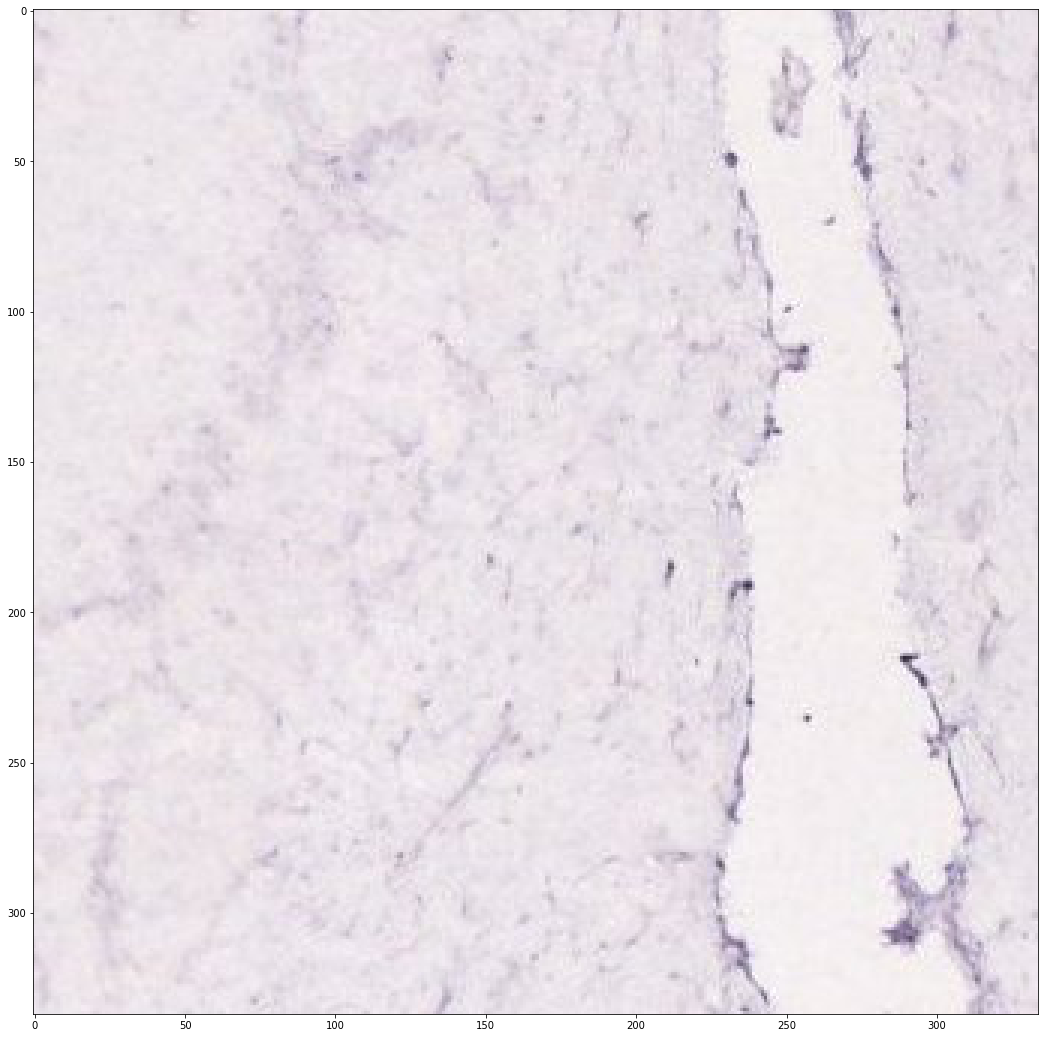

In [127]:
mob_image = df[df['structure_acronym'] == 'MOB']
verify_image(mob_image.iloc[0]["destination"])

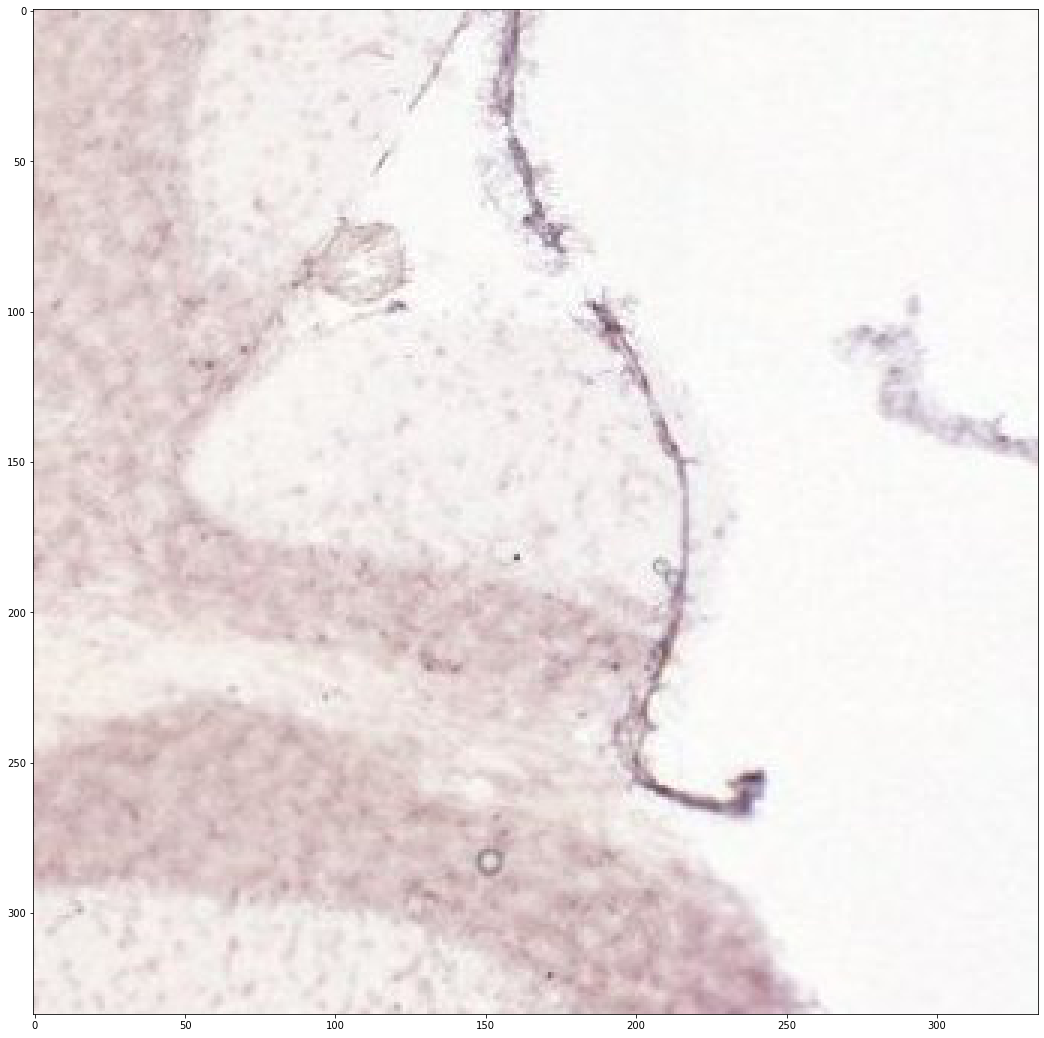

In [128]:
mob_image = df[df['structure_acronym'] == 'ANcr1']
verify_image(mob_image.iloc[0]["destination"])

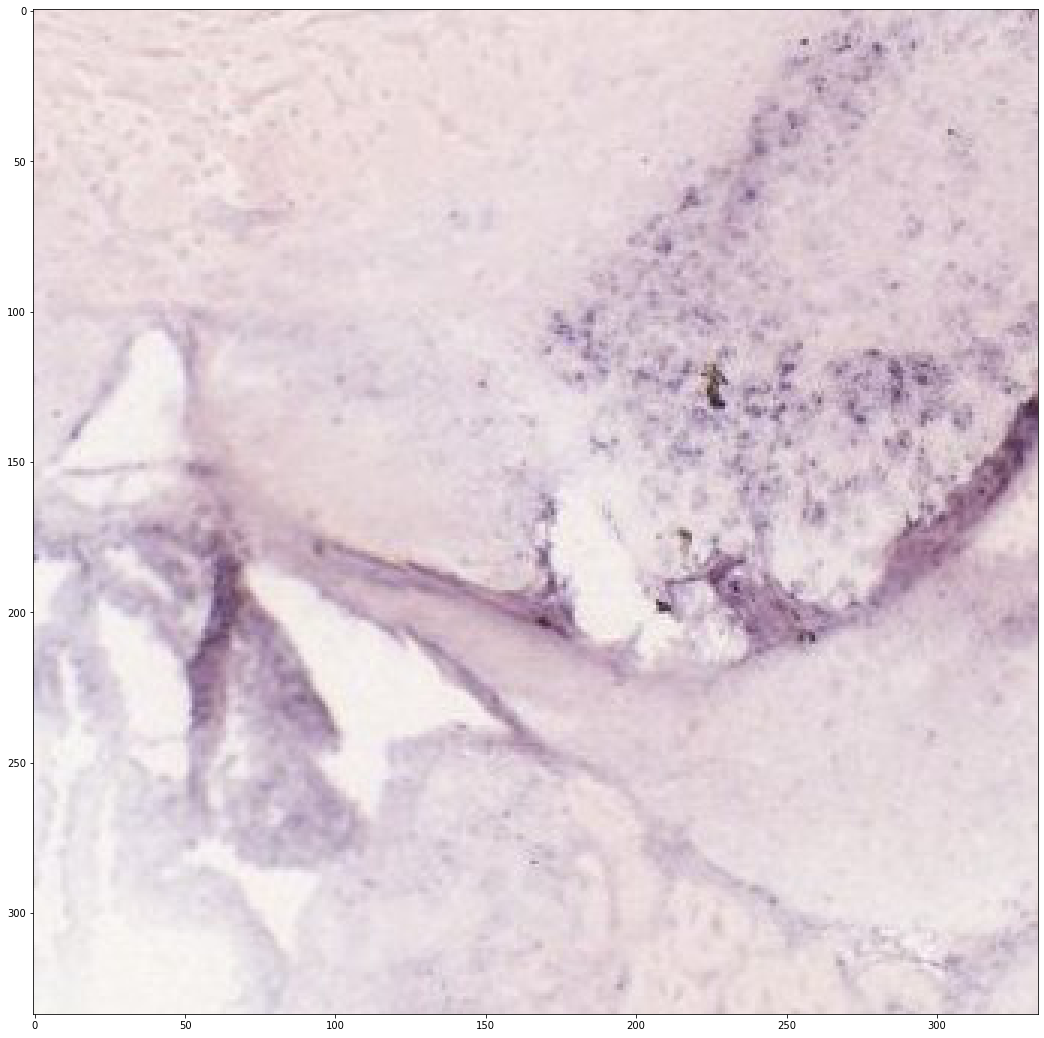

In [129]:
mob_image = df[df['structure_acronym'] == 'DG']
verify_image(mob_image.iloc[0]["destination"])

In [117]:
df.to_csv('ROIs_information', sep='\t', encoding='utf-8')
